In [2]:
!pip install imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline as SkPipeline  # sadece isim çakışmasın diye
from imblearn.pipeline import Pipeline 

#yani bu pipeline içersinden kullnamk istediğimiz fonksiyonlara erişebilecez tek tek import etmek yerine
#Pipeline(standardScaler, DecisionTree)

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression #sınıflama için
from sklearn.tree import DecisionTreeRegressor #eksik veriyi (kayıp veriyi gidermede) model tahmini ile gidermek için

from sklearn.metrics import classification_report,accuracy_score, confusion_matrix
import warnings


from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


warnings.filterwarnings("ignore")

df=pd.read_csv("healthcare-dataset-stroke-data.csv")

In [4]:
df.head()
df.shape

(5110, 12)

In [5]:
df=df.drop(["id"],axis=1)
df.shape

(5110, 11)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [7]:
describe=df.describe()
describe
#age sütünu 2 yaşına kadar ay bazında yazılmış

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


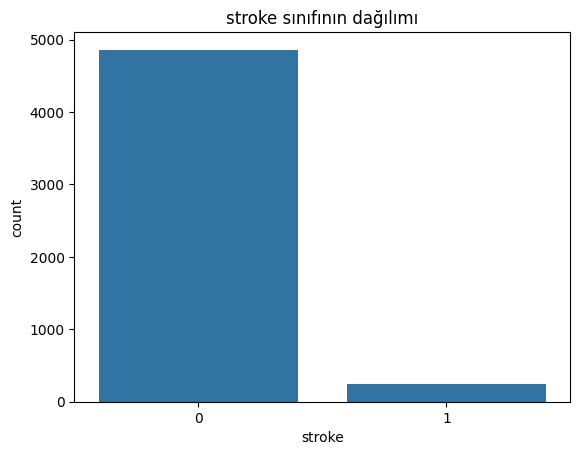

In [8]:
#stroke etiketi dağılımı
plt.figure()
sns.countplot(x="stroke",data=df)
plt.title("stroke sınıfının dağılımı")
plt.show()

#0 inme yok ; 1 inme var

In [9]:
#verimiz dengesiz

#-stroke yani 1 sayısı artmalı, yani veri toplama
#downsampling fazla olan sınıfın eleman sayısını azltma, o zaan veri kaybı olur
#diğer yöntem decisiontree kullanarak bir modelin tahminine göre eksik ksımı tamamlama

df.isnull().sum()


gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [10]:
#yaş ve cinsiyet kullnarak vücut kitle endeksini bmi deki null olanları doldurucaz
dt_bmi_pipeline=Pipeline(steps=[("scale",StandardScaler()),#veriyi standartlaştırmak için
                                ("dtr",DecisionTreeRegressor())    #eksik verinin ne olabilceğini tahmin eden model yani bnunun tahminine göre eksiği doldurcaz
])

X=df[["gender","age","bmi"]].copy()

#gender sütunu kategorik idi bunu sayısallaştıralım
#male-->0 ; female-->1 ; other-->-1 olsun

X.gender=X.gender.replace({'Male':0, 'Female':1, 'Other':-1}).astype(np.uint8)


    



In [11]:
X

,gender,age,bmi
0,0,67.0,36.6
1,1,61.0,NaN
2,0,80.0,32.5
3,1,49.0,34.4
4,1,79.0,24.0
...,...,...,...
5105,1,80.0,NaN
5106,1,81.0,40.0
5107,1,35.0,30.6
5108,0,51.0,25.6


In [12]:
#bmi değeri eksik olan satırları ayır
missing=X[X.bmi.isna()]
missing

#bmi si eksik olmayanlar
X=X[~X.bmi.isna()] #option+ü
X

y=X.pop("bmi") #X den bmi sütununu çıkardım

#modeli eksik olmayan verilerle eğit

dt_bmi_pipeline.fit(X,y)

Pipeline(steps=[('scale', StandardScaler()), ('dtr', DecisionTreeRegressor())])

In [13]:
#eksik bmi değerlerini tahmin ediyoruz bunu gender ve age kullanarak yapıyoruz
predicted_bmi=pd.Series(dt_bmi_pipeline.predict(missing[["gender","age"]]),index=missing.index)


In [14]:
df.loc[missing.index,"bmi"]=predicted_bmi


In [15]:
#kontrol
df.isnull().sum() #evet kayıp veri yok artık

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [16]:
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.879487,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.476923,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


In [17]:
#encoding adımı

df["gender"]=df["gender"].replace({'Male':0, 'Female':1, 'Other':-1}).astype(np.uint8)

df["Residence_type"]=df["Residence_type"].replace({'Rural':0, 'Urban':1}).astype(np.uint8)

df["work_type"]=df["work_type"].replace({'Private':0, 'Self-employed':1, 'Govt_job':2, "children":-1,"Never_worked":-2}).astype(np.uint8)


In [18]:
# X = df[["gender",	"age",	"hypertension" ,"heart_disease"	,"work_type"	,"avg_glucose_level",	"bmi"	]]

# train_test_split(..., stratify=y) şu işe yarar:
# Sınıf oranlarını korur. Eğitim ve test setindeki y dağılımı, orijinal verideki dağılımla yaklaşık aynı olur.
# Örn. veride stroke=1 %10 ise, test ve train’de de ~%10 kalır.

# Dengesiz veride kritik. Rastgele bölerseniz, azınlık sınıf testte çok az (hatta sıfır) kalabilir; stratify bunu önler.

X = df.drop(columns="stroke")
y=df["stroke"]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,
                                               random_state=42)

num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.columns.difference(num_cols).tolist()


prep = ColumnTransformer([
    ("num", SkPipeline([("imp", SimpleImputer(strategy="median")),
                      ("sc", StandardScaler())]), num_cols),
    ("cat", SkPipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols)
])

log_reg_pipe = Pipeline([
    ("prep", prep),
    ("smote", SMOTE(sampling_strategy=0.5, random_state=42, k_neighbors=5)), # sampling_strategy=0.5 azınlık/çoğunluk ≈ 0.5. yani yeniden örneklemeden (resampling) sonra azınlık sınıfın örnek sayısı, çoğunluk sınıfın örnek sayısının yaklaşık yarısı olsun.
    ("clf", LogisticRegression(max_iter=1000))
])
log_reg_pipe.fit(X_train, y_train)


# SMOTE, azınlık sınıfın (1) örneklerini sentetik (yeni) örneklerle çoğaltır. 
# Bunu, azınlık örneklerinin k-en yakın komşuları arasındaki çizgi üzerinde noktalar üreterek yapar.

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('sc',
                                                                   StandardScaler())]),
                                                  ['gender', 'age',
                                                   'hypertension',
                                                   'heart_disease', 'work_type',
                                                   'Residence_type',
                                                   'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('oh',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['ever_married',
                                                   'smoking_status'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('clf', LogisticRegression(max_iter=1000))])

In [19]:
y_pred=log_reg_pipe.predict(X_test)

In [20]:
print("acc: ",accuracy_score(y_test,y_pred))

acc:  0.8414872798434442


In [21]:
print("acc: ",confusion_matrix(y_test,y_pred))

acc:  [[822 150]
 [ 12  38]]


In [22]:
print("acc: ",classification_report(y_test,y_pred))

acc:                precision    recall  f1-score   support

           0       0.99      0.85      0.91       972
           1       0.20      0.76      0.32        50

    accuracy                           0.84      1022
   macro avg       0.59      0.80      0.61      1022
weighted avg       0.95      0.84      0.88      1022



In [24]:
import joblib

joblib.dump(log_reg_pipe,"log_reg_model.pkl")#model kaydet

#model yükle
loaded_model=joblib.load("log_reg_model.pkl")


In [25]:
y_pred=loaded_model.predict(X_test)

In [27]:
y_pred_prob=loaded_model.predict_proba(X_test) #olasılıksal tahmin

In [ ]:
y_pred_prob #mesela 0 .satırda %69 olasılıkla hastalık yok; %30 olasılıkla var

array([[0.69272419, 0.30727581],
       [0.90758865, 0.09241135],
       [0.96318378, 0.03681622],
       ...,
       [0.84777158, 0.15222842],
       [0.98468168, 0.01531832],
       [0.81755713, 0.18244287]])